In [1]:
import os
import re
import json
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.family'] = 'DeJavu Serif'

In [ ]:
num_opt = 3
versions = ['memory', 'context']
statuses = ['Consistent Correct', 'Conflicting Correct', 'Absent', 'Conflicting Wrong', 'Consistent Wrong']

def find_status(answer, modes):
    if len(modes) == num_opt: return 'Absent'
    if len(modes) == 1:
        if modes[0] == answer: return 'Consistent Correct'
        else: return 'Consistent Wrong'
    if answer in modes: return 'Conflicting Correct'
    else: return 'Conflicting Wrong'
    
def summarize_status(idx2answer, idx2modes):
    idx2statuses = {}
    for idx, modes in idx2modes.items():
        idx2statuses[int(idx)] = {key:find_status(idx2answer[int(idx)], modes[key]) for key in versions}
    memory, context, switch = [], [], []
    for status in statuses:
        indicies_mem = [idx for idx in range(len(idx2answer)) if idx2statuses[idx]['memory']==status]
        indicies_con = [idx for idx in range(len(idx2answer)) if idx2statuses[idx]['context']==status]
        memory.append(len(indicies_mem)); context.append(len(indicies_con)); switch.append([])
        for status_swi in statuses:
            indicies_swi = [idx for idx in indicies_mem if idx2statuses[idx]['context']==status_swi]
            switch[-1].append(len(indicies_swi))
    memory, context, switch = np.array(memory), np.array(context), np.array(switch)
    memory, context, switch = memory / memory.sum(), context / context.sum(), switch / (switch.sum(axis=1, keepdims=True) + 1e-10)
    return memory, context, switch

def get_results(data, abbre2model):
    dataset = pd.read_csv(f'Data/Input/{data}.csv')
    idx2answer = {idx:answer for idx, answer in enumerate(dataset['answer'])}
    model2memory, model2context, model2switch = {}, {}, {}
    for abbre, model in abbre2model.items():
        file = f'Data/Status/{data}/{model}.json'
        if not os.path.exists(file): continue
        idx2modes = json.load(open(file))
        model2memory[abbre], model2context[abbre], model2switch[abbre] = summarize_status(idx2answer, idx2modes)
    return model2memory, model2context, model2switch

In [5]:
datas = ['Hemonc', 'PubMedQA', 'NQ', 'HotpotQA']
families = ['Gemma', 'Llama', 'Qwen']
abbre2model = {'Gemma-2B':'gemma-2-2b-it', 'Gemma-9B':'gemma-2-9b-it', 'Gemma-27B':'gemma-2-27b-it', 
               'Llama-3B':'Llama-3.2-3B-Instruct', 'Llama-8B':'Llama-3.1-8B-Instruct', 'Llama-70B':'Llama-3.3-70B-Instruct', 
               'Qwen-3B':'Qwen2.5-3B-Instruct', 'Qwen-7B':'Qwen2.5-7B-Instruct', 'Qwen-14B':'Qwen2.5-14B-Instruct'}
data2model2memory, data2model2context, data2model2switch = {}, {}, {}
for data in datas:
    data2model2memory[data], data2model2context[data], data2model2switch[data] = get_results(data, abbre2model)
    
results = []
for version, data2model2ratio in zip(versions, [data2model2memory, data2model2context]):
    for data, model2ratio in data2model2ratio.items():
        for model, ratio in model2ratio.items():
            family, size = model.split('-')
            size = int(size[:-1])
            results.append((version, data, family, size, *ratio))
results = pd.DataFrame(results, columns=['version', 'data', 'family', 'size']+statuses)
average_data = results.groupby(['version', 'family', 'size'])[statuses].mean().reset_index()
average_model = results.groupby(['version', 'data'])[statuses].mean().reset_index()
average_switch = np.mean([[data2model2switch[data][model][:,0], data2model2switch[data][model][:,1:].sum(-1)] 
                          for data in datas for model in abbre2model], axis=0)

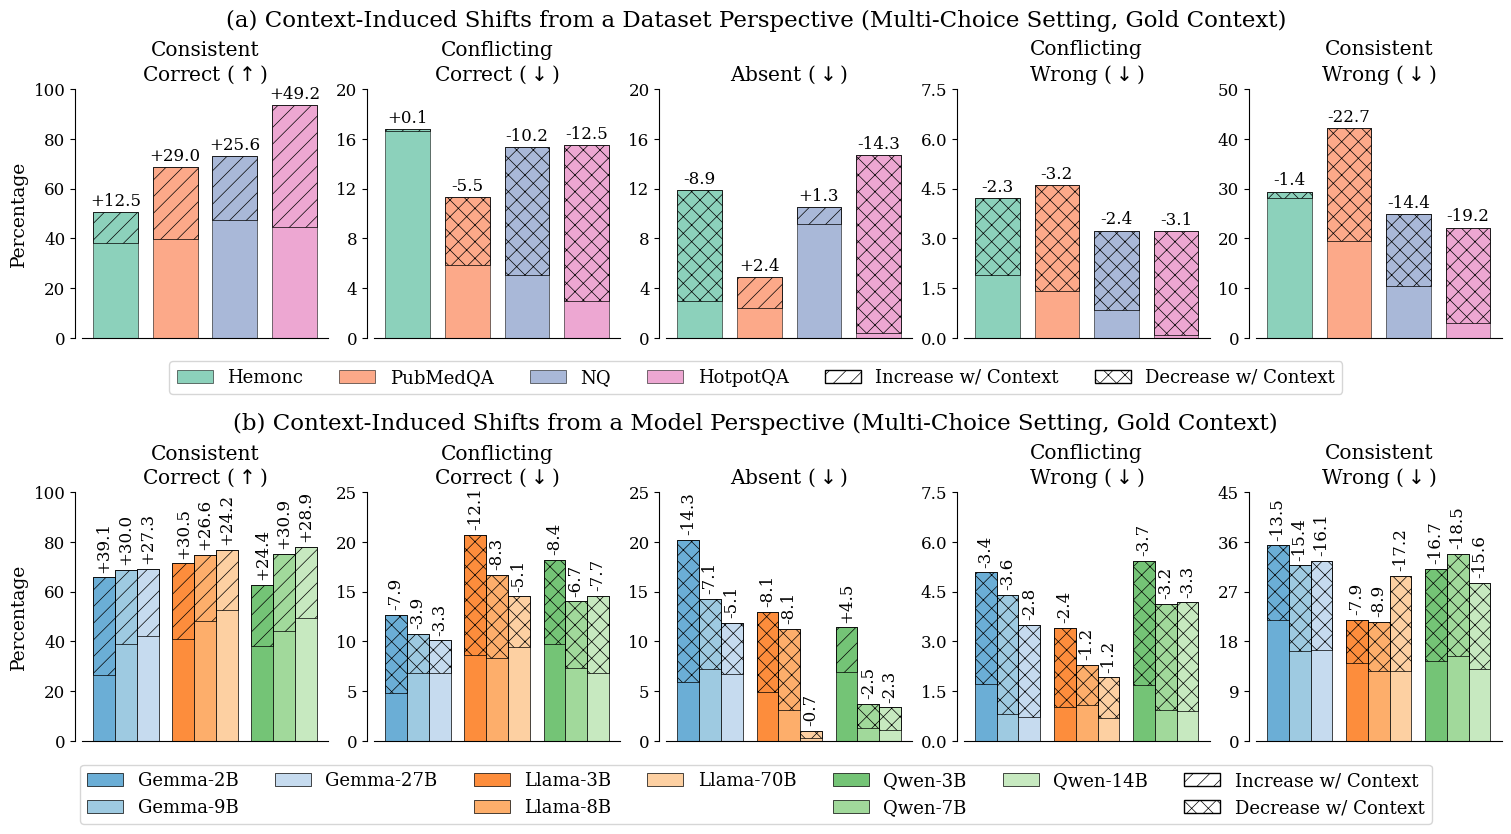

In [ ]:
fontsize, alpha, lw = 13, 0.75, 0.5
colors_top = sns.color_palette("Set2", len(datas))
colors_bot = sns.color_palette("tab20c")
colors_bot = [colors_bot[i] for i in [1,2,3,5,6,7,9,10,11]]

num_row, num_col = 2, 5
size_row, size_col = 3.75, 3
fig = plt.figure(figsize=(num_col*size_col, num_row*size_row), constrained_layout=True)
subfigs = fig.subfigures(nrows=num_row, ncols=1, height_ratios=[1, 1])
axs_top, axs_bot = subfigs[0].subplots(1, num_col), subfigs[1].subplots(1, num_col)

fig.set_constrained_layout_pads(hspace=0.15)
subfigs[0].suptitle("(a) Context-Induced Shifts from a Dataset Perspective (Multi-Choice Setting, Gold Context)", fontsize=fontsize+3.5)
subfigs[1].suptitle("(b) Context-Induced Shifts from a Model Perspective (Multi-Choice Setting, Gold Context)", fontsize=fontsize+3.5)
plt.rcParams['hatch.linewidth'] = lw

width = 0.75
sid2top = {0:1, 1:0.2, 2:0.2, 3:0.075, 4:0.5}
for sid, status in enumerate(statuses):
    sns.despine(ax=axs_top[sid], offset=dict(left=5))
    axs_top[sid].set_ylim(top=sid2top[sid]*100)
    axs_top[sid].set_yticks(np.linspace(0, sid2top[sid]*100, 6))
    axs_top[sid].tick_params(axis='both', which='major', labelsize=fontsize-1, labelbottom=False, bottom=False)
    axs_top[sid].set_title(status.replace(' ', '\n') + (r' ($\downarrow$)' if sid else r' ($\uparrow$)'), fontsize=fontsize+1.5)
    
    for did, data in enumerate(datas):        
        average_memory = average_model[(average_model['version']=='memory') & (average_model['data']==data)][status].to_numpy()
        average_context = average_model[(average_model['version']=='context') & (average_model['data']==data)][status].to_numpy()
        average_max = np.max((average_memory, average_context), axis=0)
        diffs = average_context - average_memory
        hatches = ['//' if diff >= 0 else 'xx' for diff in diffs]
        
        axs_top[sid].bar(did, average_max*100, label=data,
                         width=width, color=colors_top[did], alpha=alpha, edgecolor='black', lw=lw)
        axs_top[sid].bar(did, diffs*100, bottom=average_memory*100, 
                         width=width, facecolor='none', edgecolor='black', hatch=hatches, lw=lw)
        for top, diff in zip(average_context, diffs):
            axs_top[sid].text(did, (sid2top[sid]*0.01+max(top,top-diff))*100, f'{diff*100:+.1f}', 
                              fontsize=fontsize-1, ha='center', va='bottom')

axs_top[0].set_ylabel(f'Percentage', fontsize=fontsize+0.5)
handles, labels = axs_top[0].get_legend_handles_labels()
handles += [
    Patch(facecolor='white', edgecolor='black', hatch='//'),
    Patch(facecolor='white', edgecolor='black', hatch='xx')
]
labels += [
    'Increase w/ Context', 'Decrease w/ Context'
]
subfigs[0].legend(handles, labels, fontsize=fontsize, ncol=len(labels),
                  bbox_to_anchor=(0.5,0), loc='upper center', bbox_transform=subfigs[0].transSubfigure)

num_bar = 3
width = 0.275
xs = (np.arange(num_bar) - (num_bar-1)/2) * width

sid2top = {0:1, 1:0.25, 2:0.25, 3:0.075, 4:0.45}
for sid, status in enumerate(statuses):
    sns.despine(ax=axs_bot[sid], offset=dict(left=5))
    axs_bot[sid].set_ylim(top=sid2top[sid]*100)
    axs_bot[sid].set_yticks(np.linspace(0, sid2top[sid]*100, 6))
    axs_bot[sid].tick_params(axis='both', which='major', labelsize=fontsize-1, labelbottom=False, bottom=False)
    axs_bot[sid].set_title(status.replace(" ", "\n") + (r' ($\downarrow$)' if sid else r' ($\uparrow$)'), fontsize=fontsize+1.5)
        
    for fid, family in enumerate(families):        
        average_memory = average_data[(average_data['version']=='memory') & (average_data['family']==family)][status].to_numpy()
        average_context = average_data[(average_data['version']=='context') & (average_data['family']==family)][status].to_numpy()
        average_max = np.max((average_memory, average_context), axis=0)
        diffs = average_context - average_memory
        hatches = ['//' if diff >= 0 else 'xx' for diff in diffs]
        
        models = list(abbre2model.keys())[fid*num_bar:(fid+1)*num_bar]
        axs_bot[sid].bar(fid+xs, average_max*100, label=models, 
                         width=width, color=colors_bot[fid*num_bar:(fid+1)*num_bar], edgecolor='black', lw=lw)
        axs_bot[sid].bar(fid+xs, diffs*100, bottom=average_memory*100, 
                         width=width, facecolor='none', edgecolor='black', hatch=hatches, lw=lw)
        for x, top, diff in zip(xs, average_context, diffs):
            axs_bot[sid].text(fid+x, (sid2top[sid]*0.02+max(top,top-diff))*100, f'{diff*100:+.1f}', 
                              fontsize=fontsize-1, ha='center', va='bottom', rotation='vertical')

axs_bot[0].set_ylabel(f'Percentage', fontsize=fontsize+0.5)
handles, labels = axs_bot[0].get_legend_handles_labels()
empty = Patch(facecolor='none', edgecolor='none')
handles = handles[:3] + [empty] + handles[3:6] + [empty] + handles[6:] + [empty]
labels = labels[:3] + [''] + labels[3:6] + [''] + labels[6:] + ['']
handles += [
    Patch(facecolor='white', edgecolor='black', hatch='//'),
    Patch(facecolor='white', edgecolor='black', hatch='xx')
]
labels += [
    'Increase w/ Context', 'Decrease w/ Context'
]
subfigs[1].legend(handles, labels, fontsize=fontsize, ncol=7,
                  bbox_to_anchor=(0.5,0), loc='upper center', bbox_transform=subfigs[1].transSubfigure)

plt.savefig('Figure/ave_shift.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

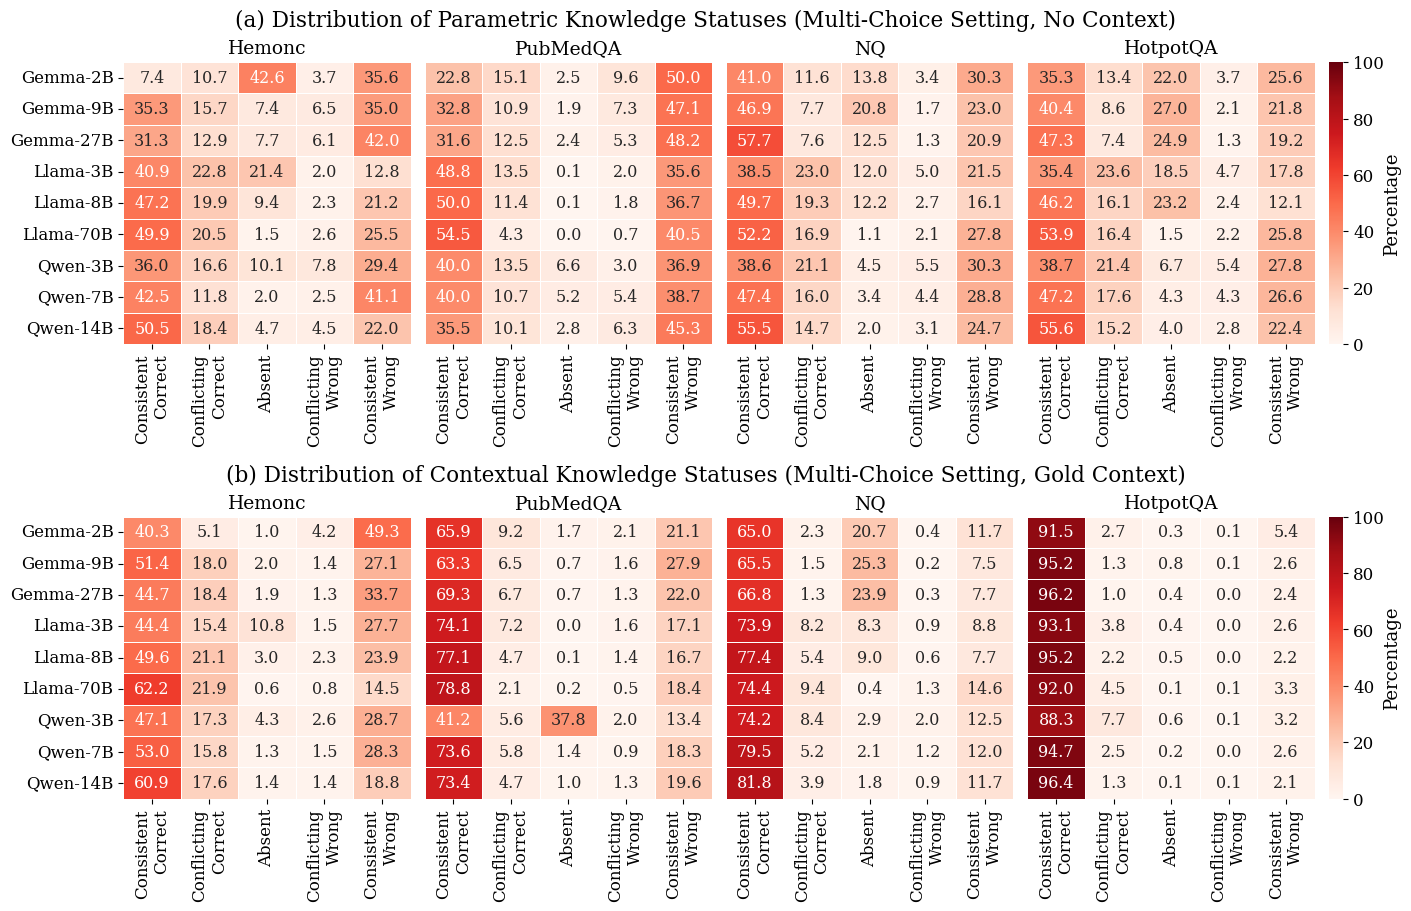

In [ ]:
def draw_subfig(sfid, version, data2model2status):
    
    axs = subfigs[sfid].subplots(1, num_col, gridspec_kw={'wspace':0.04})
    subfigs[sfid].suptitle(f"({'b' if sfid else 'a'}) Distribution of {version} Knowledge Statuses (Multi-Choice Setting, {'No' if version == 'Parametric' else 'Gold'} Context)",
                           fontsize=fontsize+3.5)
    
    for idx, data in enumerate(datas):
        status = np.array([data2model2status[data].get(model, np.zeros(len(statuses))) for model in abbre2model])
        sns.heatmap(status*100, ax=axs[idx], linewidth=0.5, vmin=vmin, vmax=vmax, 
                    yticklabels=idx==0, annot=True, fmt=".1f", annot_kws={'fontsize':fontsize-0.5}, 
                    cmap="Reds", cbar=idx==len(datas)-1, cbar_kws={'label':'Percentage'})
        axs[idx].set_title(data, fontsize=fontsize+1.5)
        axs[idx].set_xticklabels(xticklabels, fontsize=fontsize, ha='right', va='center', 
                                 rotation=90, rotation_mode="anchor")

    axs[0].set_yticklabels(abbre2model.keys(), rotation=0, ha='right', va='center', fontsize=fontsize)
    cbar = axs[-1].collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.yaxis.label.set_size(fontsize+1)
    cbar.ax.yaxis.labelpad = -1

fontsize = 12
vmin, vmax = 0, 100
num_col, num_row = len(datas), 2
sub_col, sub_row = len(statuses), len(abbre2model)
size_col, size_row = 0.7, 0.5

fig = plt.figure(figsize=(num_col*sub_col*size_col, num_row*sub_row*size_row), constrained_layout=True)
subfigs = fig.subfigures(nrows=num_row, ncols=1, height_ratios=[1, 1])
xticklabels = ['Consistent\nCorrect', 'Conflicting\nCorrect', 'Absent', 'Conflicting\nWrong', 'Consistent\nWrong']

draw_subfig(0, 'Parametric', data2model2memory)
draw_subfig(1, 'Contextual', data2model2context)

plt.savefig('Figure/status_dist.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

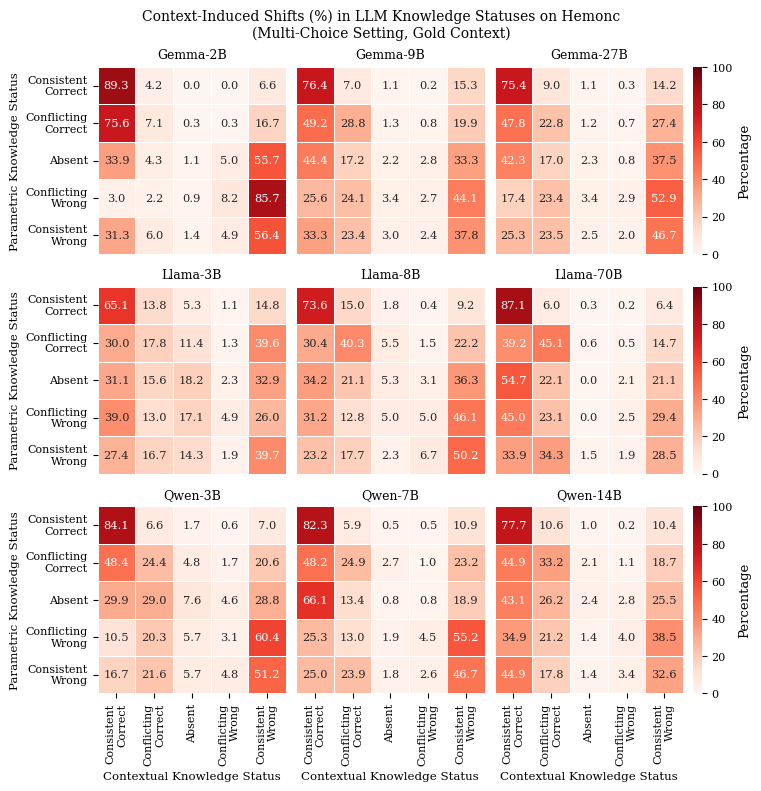

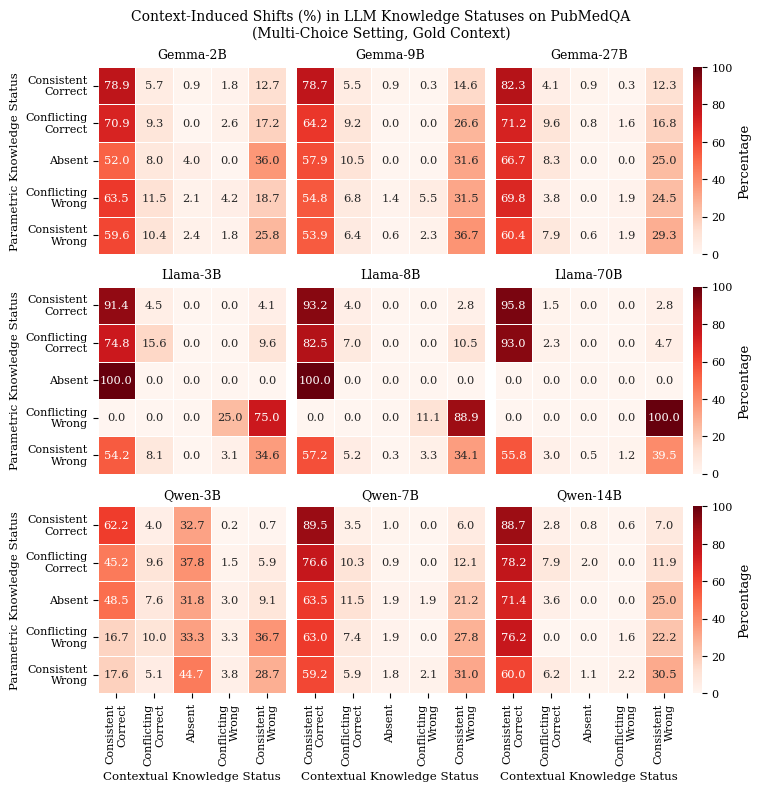

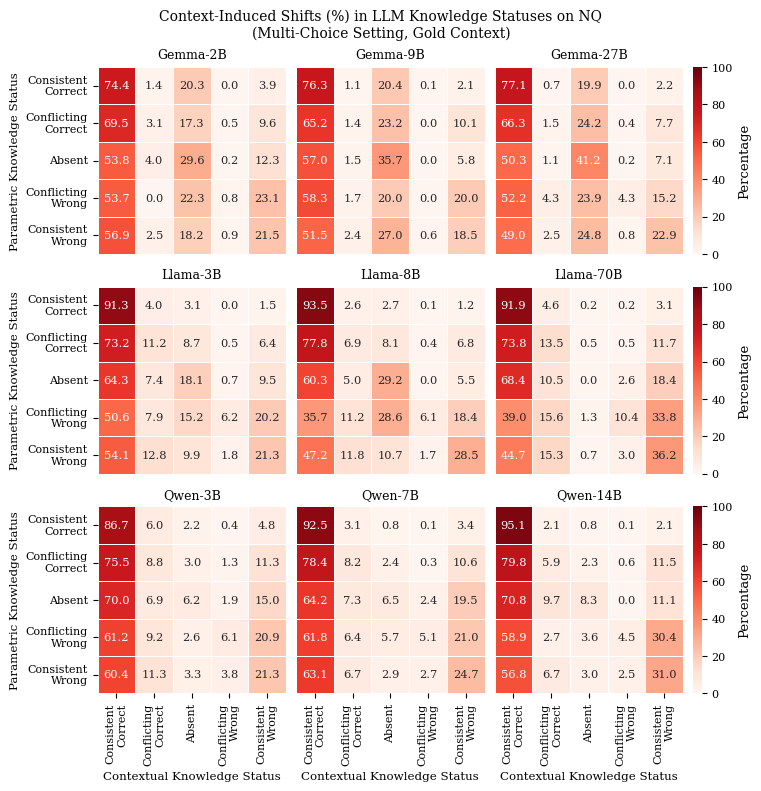

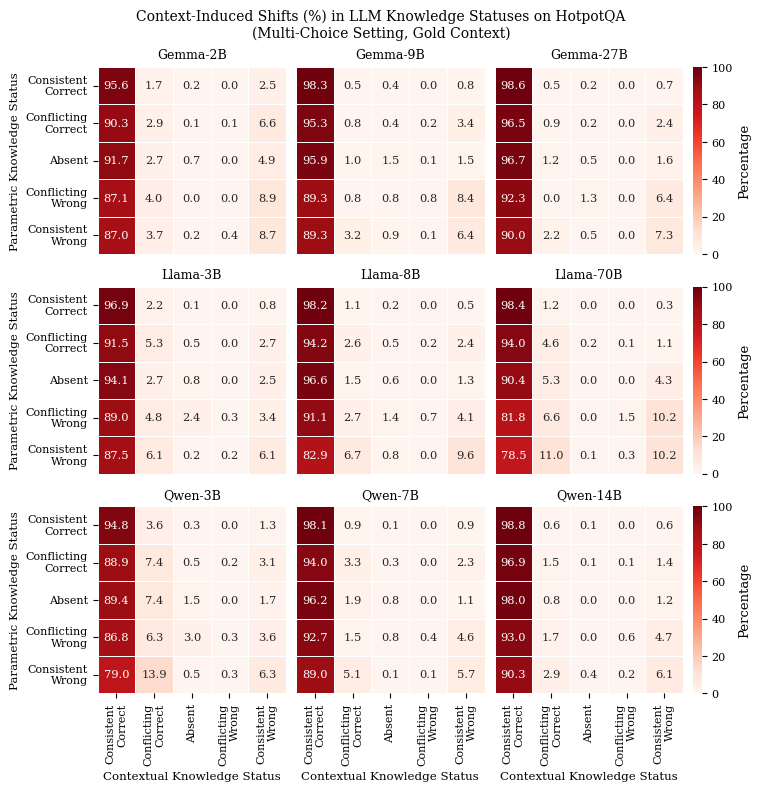

In [ ]:
def draw_switch(data):
    fontsize = 10 # 11.5
    vmin, vmax = 0, 100
    num_col, num_row = 3, 3
    sub_col, sub_row = len(statuses), len(statuses)
    size_col, size_row = 0.5, 0.52 # 0.65, 0.65
    fig, axs = plt.subplots(num_row, num_col, constrained_layout=True, gridspec_kw={'wspace':0.04, 'hspace':0.01},
                            figsize=(num_col*sub_col*size_col, num_row*sub_row*size_row))

    for idx, model in enumerate(abbre2model):
        idx_r, idx_c = idx//num_col, idx%num_col
        sns.heatmap(100*data2model2switch[data].get(model, np.zeros((len(statuses), len(statuses)))), 
                    ax=axs[idx_r][idx_c], linewidth=0.5, vmin=vmin, vmax=vmax, 
                    yticklabels=idx_c==0, xticklabels=idx_r==num_row-1, 
                    annot=True, fmt=".1f", annot_kws={'fontsize':fontsize-1.75}, 
                    cmap="Reds", cbar=idx_c==num_col-1, cbar_kws={'label':'Percentage'})
        axs[idx_r][idx_c].set_title(model, fontsize=fontsize-1)

        if idx_r == num_row-1:
            axs[idx_r][idx_c].set_xlabel('Contextual Knowledge Status', fontsize=fontsize-1.5)
            axs[idx_r][idx_c].set_xticklabels(['\n'.join(c.split(' ')) for c in statuses], rotation=90, ha='right', 
                                              va='center', rotation_mode='anchor', fontsize=fontsize-2)

        if idx_c == 0:
            axs[idx_r][idx_c].set_ylabel('Parametric Knowledge Status', fontsize=fontsize-1.5)
            axs[idx_r][idx_c].set_yticklabels(['\n'.join(c.split(' ')) for c in statuses], rotation=0, ha='right', 
                                              va='center', fontsize=fontsize-2)

        if idx_c == num_col-1:
            cbar = axs[idx_r][idx_c].collections[0].colorbar
            cbar.ax.tick_params(labelsize=fontsize-2)
            cbar.ax.yaxis.label.set_size(fontsize-0.5)

    fig.suptitle(f'Context-Induced Shifts (%) in LLM Knowledge Statuses on {data}\n(Multi-Choice Setting, Gold Context)', fontsize=fontsize)
    plt.savefig(f'Figure/switch_{data}.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
for data in datas:
    draw_switch(data)